In [9]:
import typing

import gigaam # pyright: ignore[reportMissingTypeStubs]
from gigaam.model import GigaAMASR # pyright: ignore[reportMissingTypeStubs]
from datasets import load_dataset, Audio # type:ignore
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from asr_eval.models.gigaam import transcribe_with_gigaam_ctc
from asr_eval.force_alignment import force_alignment, plot_alignments, plot_trellis_with_path

In [10]:
dataset = load_dataset('bond005/sberdevices_golos_100h_farfield', split='train')
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000)) # type:ignore

In [11]:
model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

салют включи музыку в жанре лаунж


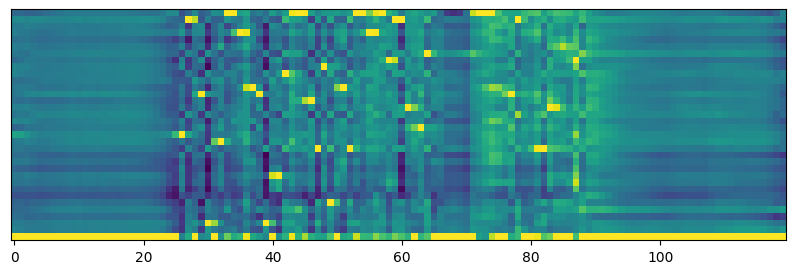

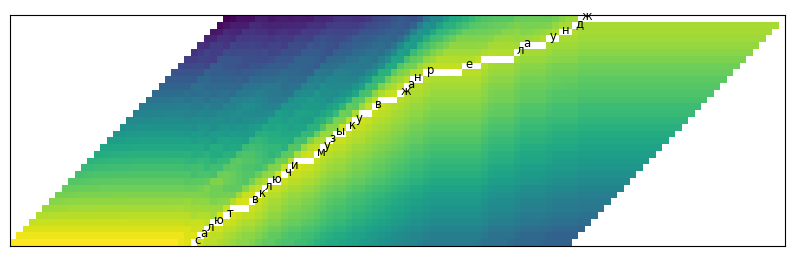

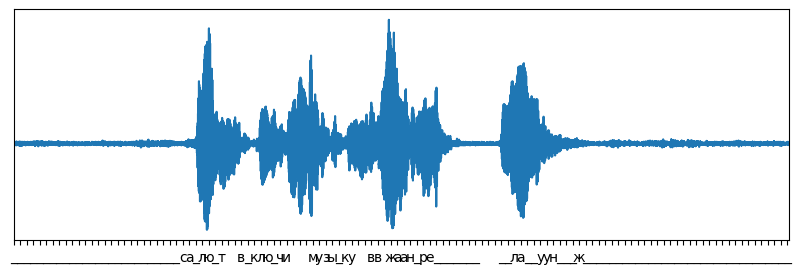

In [37]:
sample = dataset[22] # type: ignore
true_text: str = sample['transcription'] # type: ignore
true_tokens = [model.decoding.tokenizer.vocab.index(x) for x in true_text]
waveform = typing.cast(npt.NDArray[np.float64], sample['audio']['array']) # type: ignore
output = transcribe_with_gigaam_ctc(model, [waveform])[0]

segments, path, trellis = force_alignment(output.log_probs, true_tokens, model.decoding.blank_id)

print(output.text)

plt.figure(figsize=(10, 3)) # type: ignore
plt.imshow(output.log_probs.T, aspect='auto') # type: ignore
plt.yticks([]) # type: ignore
plt.show() # type: ignore

plot_alignments(segments, trellis, model.decoding.tokenizer.vocab, path=path, figsize=(10, 3))
output.visualize(model, waveform, figsize=(10, 3))

In [38]:
path

[Point(token_seq_index=0, time_index=28, score=0.041732970625162125),
 Point(token_seq_index=1, time_index=29, score=0.9999990463256836),
 Point(token_seq_index=2, time_index=30, score=0.9999970197677612),
 Point(token_seq_index=3, time_index=31, score=2.2802623789175414e-07),
 Point(token_seq_index=3, time_index=32, score=0.9999920725822449),
 Point(token_seq_index=4, time_index=33, score=0.9989748001098633),
 Point(token_seq_index=5, time_index=34, score=0.9998883008956909),
 Point(token_seq_index=5, time_index=35, score=1.4186401813276461e-06),
 Point(token_seq_index=5, time_index=36, score=0.43406355381011963),
 Point(token_seq_index=6, time_index=37, score=0.999991774559021),
 Point(token_seq_index=7, time_index=38, score=0.9999973773956299),
 Point(token_seq_index=8, time_index=39, score=0.9999973177909851),
 Point(token_seq_index=9, time_index=40, score=8.881384019332472e-07),
 Point(token_seq_index=9, time_index=41, score=0.9999868273735046),
 Point(token_seq_index=10, time_ind

In [36]:
from dataclasses import dataclass
from functools import lru_cache

@dataclass
class FA_Path:
    current_token_id: int
    current_log_p: float
    tail_log_p: float
    tail_token_ids: list[int]
    
    @property
    def total_log_p(self) -> float:
        return self.current_log_p + self.tail_log_p

log_probs: npt.NDArray[np.floating] = output.log_probs
true_tokens: list[int] | npt.NDArray[np.integer]

@lru_cache(maxsize=None)
def fa(
    log_probs_start_idx: int = 0,
    true_tokens_start_idx: int = 0,
    blank_id: int = 0,
    _prev_token_id: int | None = None
) -> tuple[float, list[int]]:
    
    if _prev_token_id is None:
        _prev_token_id = blank_id
    
    if log_probs_start_idx >= len(log_probs):
        if true_tokens_start_idx >= len(true_tokens):
            return 1, []
        else:
            return -np.inf, []
    
    if true_tokens_start_idx < len(true_tokens):
        assert true_tokens[true_tokens_start_idx] != blank_id
    
    # option 1: blank token
    path_1 = FA_Path(
        blank_id,
        log_probs[log_probs_start_idx, blank_id],
        *fa(log_probs_start_idx + 1, true_tokens_start_idx, blank_id, blank_id),
    )
    best_path = path_1
    
    # option 2: prev token that is not blank token
    if _prev_token_id != blank_id:
        path_2 = FA_Path(
            _prev_token_id,
            log_probs[log_probs_start_idx, _prev_token_id],
            *fa(log_probs_start_idx + 1, true_tokens_start_idx, blank_id, _prev_token_id),
        )
        if path_2.total_log_p > best_path.total_log_p:
            best_path = path_2
    
    # option 3: true_tokens[0] that is not the same as prev token
    if true_tokens_start_idx < len(true_tokens) and true_tokens[true_tokens_start_idx] != _prev_token_id:
        path_3 = FA_Path(
            true_tokens[true_tokens_start_idx],
            log_probs[log_probs_start_idx, true_tokens[true_tokens_start_idx]],
            *fa(log_probs_start_idx + 1, true_tokens_start_idx + 1, blank_id, true_tokens[true_tokens_start_idx]),
        )
        if path_3.total_log_p > best_path.total_log_p:
            best_path = path_3
    
    return best_path.total_log_p, [best_path.current_token_id] + best_path.tail_token_ids

log_p, path_fa = fa(0, 0, model.decoding.blank_id)
''.join([
    model.decoding.tokenizer.vocab[token_id]
    if token_id != model.decoding.blank_id
    else '_'
    for token_id in path_fa
])

'__________________________са_лю_т  в_клю_чи   музы_ку  вв жаан_ре_______   __ла__уун_д_ж________________________________'